In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!kaggle datasets download -d pybear/cats-vs-dogs

Dataset URL: https://www.kaggle.com/datasets/pybear/cats-vs-dogs
License(s): CC0-1.0
 99% 776M/788M [00:07<00:00, 107MB/s] 
100% 788M/788M [00:07<00:00, 104MB/s]


In [4]:
!unzip cats-vs-dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/550.jpg   
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  

##Import the Modules

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator


##Create dataframe for input and output

In [6]:
input_path = []
label = []

for classname in os.listdir("PetImages"):
  for path in os.listdir("PetImages/"+classname):
    if classname == 'Cat':
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join("PetImages", classname, path))


In [7]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop = True)
df.head()

images  label
0  PetImages/Cat/1182.jpg      0
1  PetImages/Cat/1470.jpg      0
2   PetImages/Dog/412.jpg      1
3  PetImages/Cat/8648.jpg      0
4  PetImages/Cat/1485.jpg      0

In [23]:
# delete db files
for i in df['images']:
  if '.jpg' not in i:
    print(i)


PetImages/Cat/Thumbs.db
PetImages/Dog/Thumbs.db


In [24]:
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Dog/Thumbs.db']


len(df)


25000

In [30]:
df = df[df['images']!='PetImages/Dog/11702.jpg']
df = df[df['images']!='PetImages/Cat/666.jpg']

In [29]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

['PetImages/Dog/11702.jpg', 'PetImages/Cat/666.jpg']

In [31]:
plt.figure(figsize=(15,15))
temp = df[df['label']==1]['images']
start = random.randint(0,len(temp))
files = temp[start: start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title("Dogs")
  plt.axis("off")


<Figure size 1500x1500 with 0 Axes>

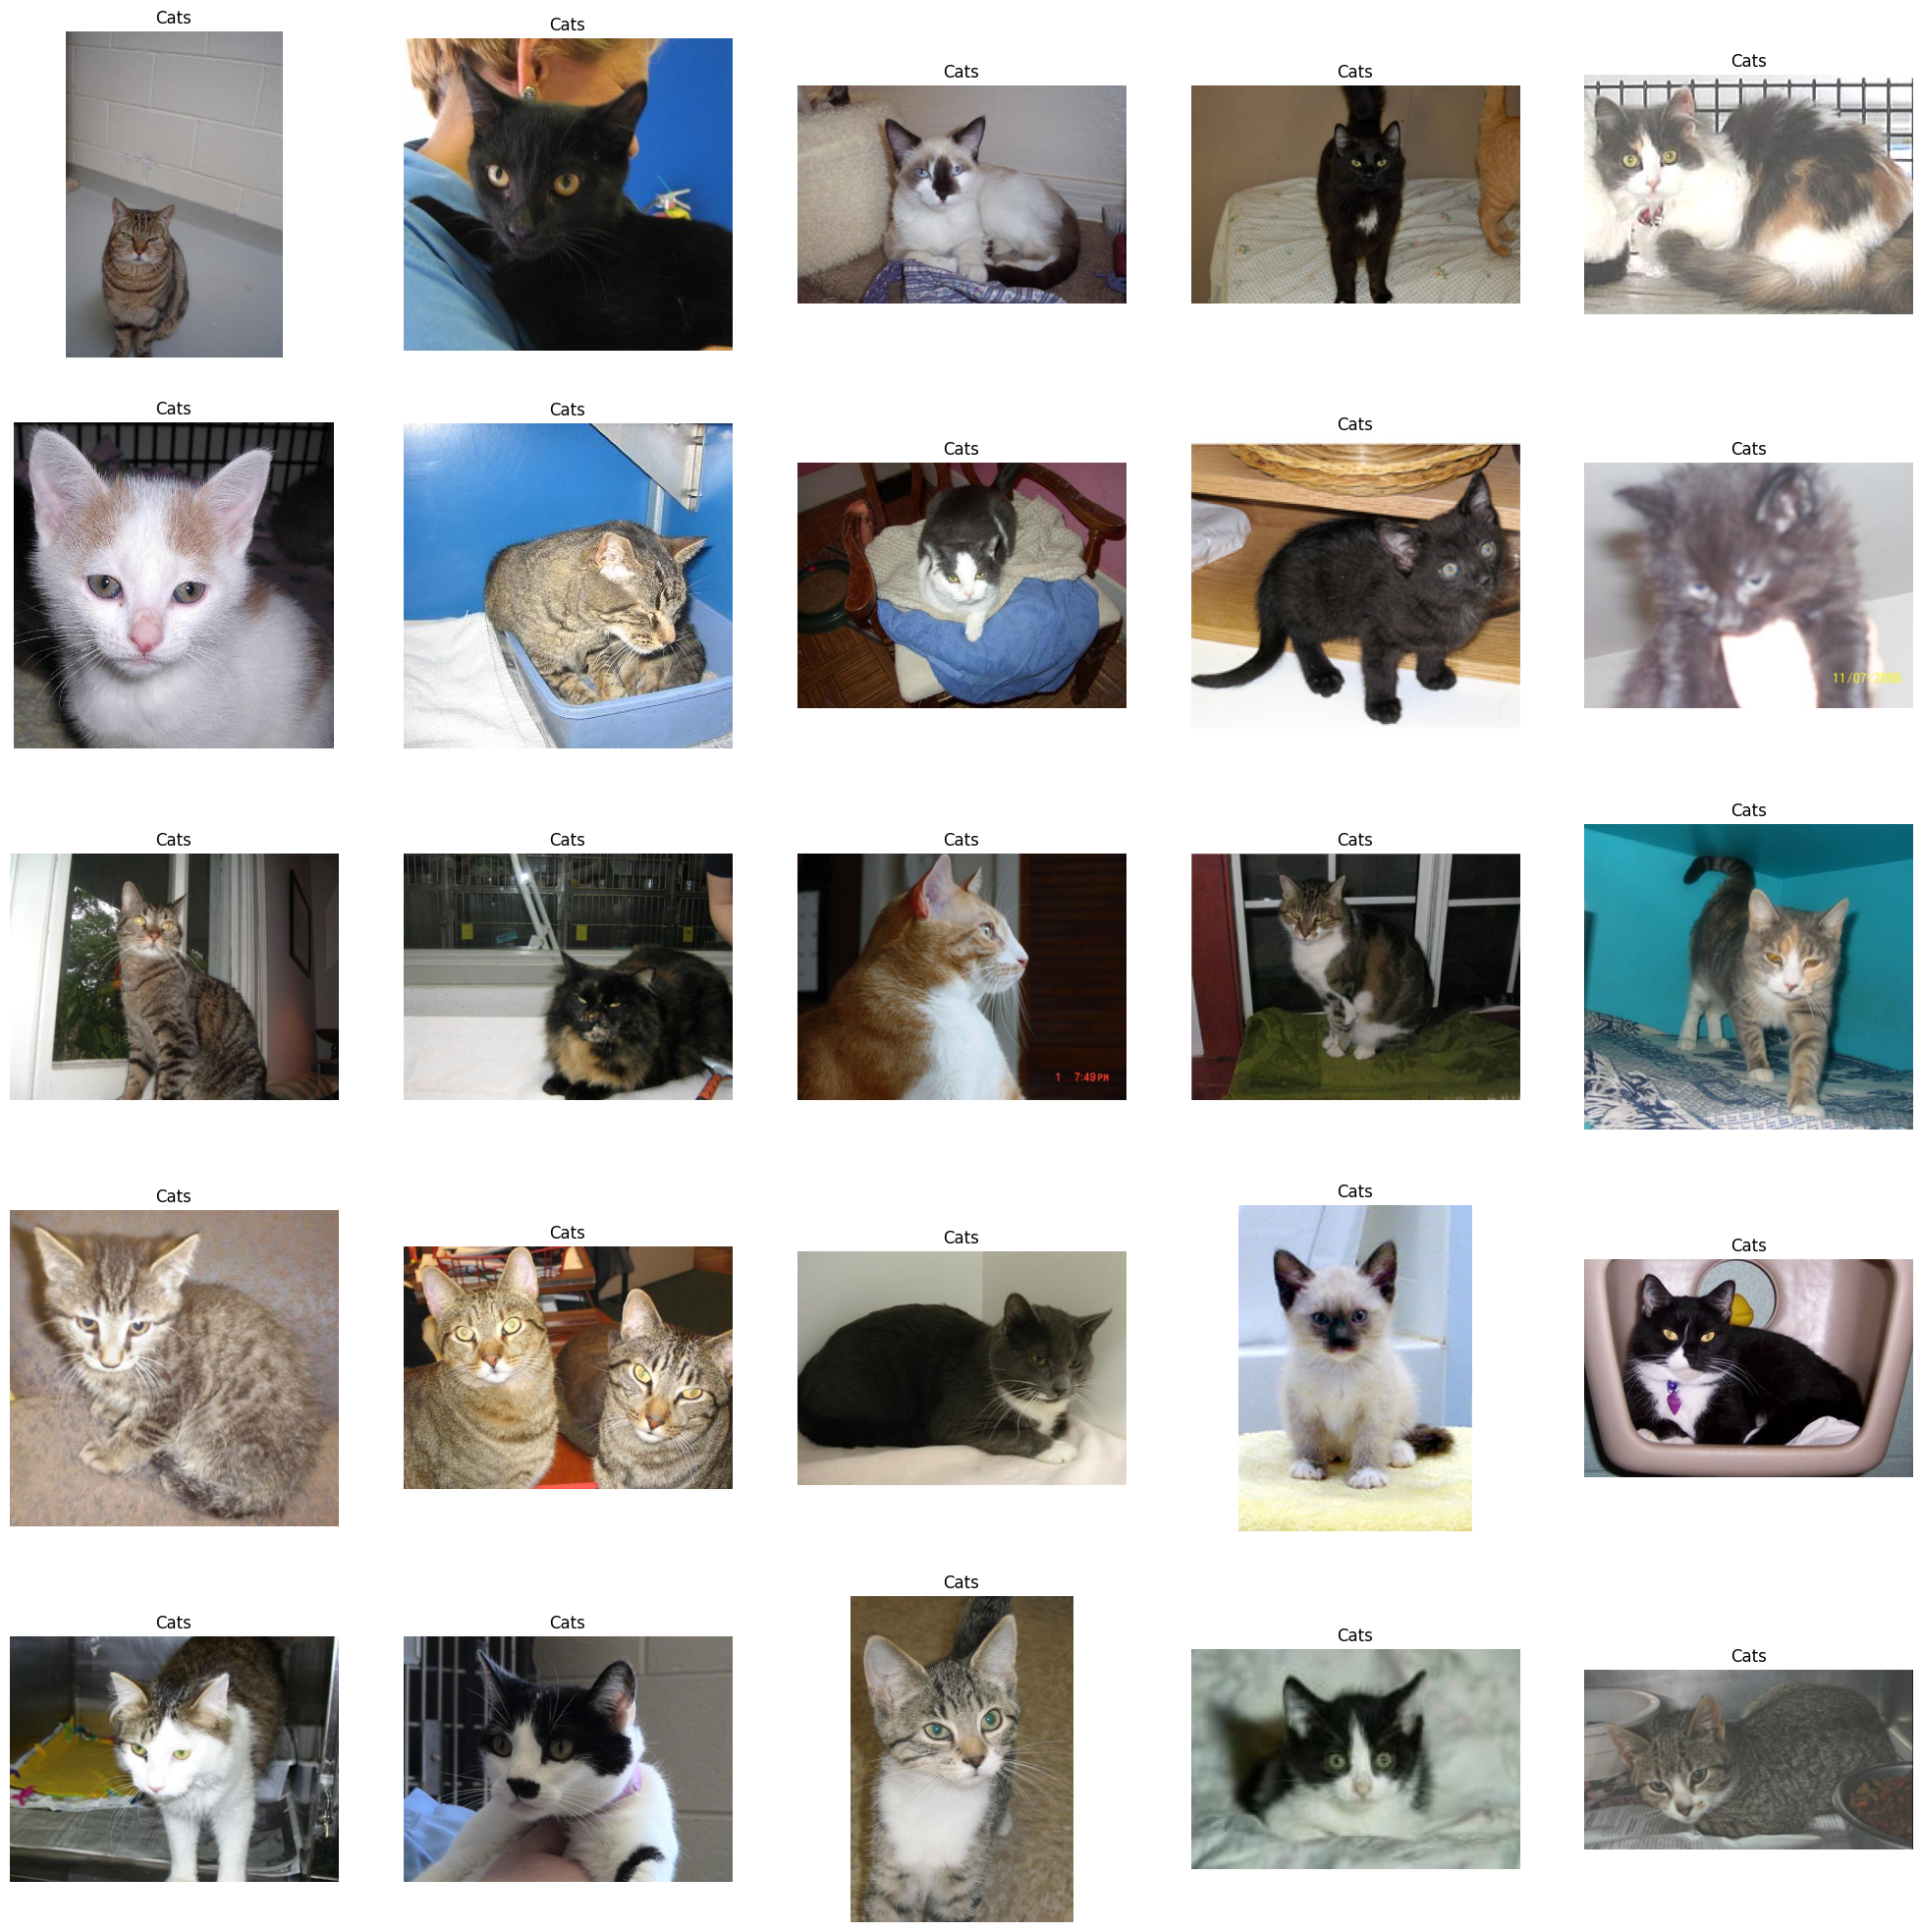

In [9]:
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0,len(temp))
files = temp[start: start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title("Cats")
  plt.axis("off")

In [32]:
df['label'] = df['label'].astype('str')

In [33]:
df.head()

images label
0  PetImages/Cat/1182.jpg     0
1  PetImages/Cat/1470.jpg     0
2   PetImages/Dog/412.jpg     1
3  PetImages/Cat/8648.jpg     0
4  PetImages/Cat/1485.jpg     0

##input split

In [34]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df, test_size=0.2, random_state=42)

In [42]:
train_generator = ImageDataGenerator(
    rescale = 1./255 #Normalization of image
)

validation_generator = ImageDataGenerator(rescale=1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col = 'images',
    y_col = 'label',
    target_size =(128,128),
    batch_size = 512,
    class_mode = 'binary'
)

validation_iterator = validation_generator.flow_from_dataframe(
    test,
    x_col = 'images',
    y_col = 'label',
    target_size =(128,128),
    batch_size = 512,
    class_mode = 'binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Model creation

In [43]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
                   Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                   MaxPooling2D(2,2),
                   Conv2D(32, (3,3), activation='relu'),
                   MaxPooling2D(2,2),
                   Conv2D(64, (3,3), activation='relu'),
                   MaxPooling2D(2,2),
                   Flatten(),
                   Dense(512, activation='relu'),
                   Dense(1, activation='sigmoid')
])

In [44]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,447,137 (24.59 MB)

 Trainable params: 6,447,137 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history = model.fit(train_iterator, epochs=10, validation_data = validation_iterator)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5197 - loss: 0.7304 - val_accuracy: 0.6028 - val_loss: 0.6614
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6246 - loss: 0.6435 - val_accuracy: 0.6930 - val_loss: 0.5747
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7105 - loss: 0.5612 - val_accuracy: 0.7458 - val_loss: 0.5158
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7486 - loss: 0.5083 - val_accuracy: 0.7518 - val_loss: 0.5077
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 995ms/step - accuracy: 0.7590 - loss: 0.4935 - val_accuracy: 0.7768 - val_loss: 0.4682
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7860 - loss: 0.4579 - val_accuracy: 0.7840 - val_loss: 0.4644
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 79s 977ms/step - accuracy: 0.7922 - loss: 0.4450 - val_accuracy: 0.7914 - val_loss: 0.4440
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8135 - loss: 0.4168 - val_accuracy: 0.8106 - val

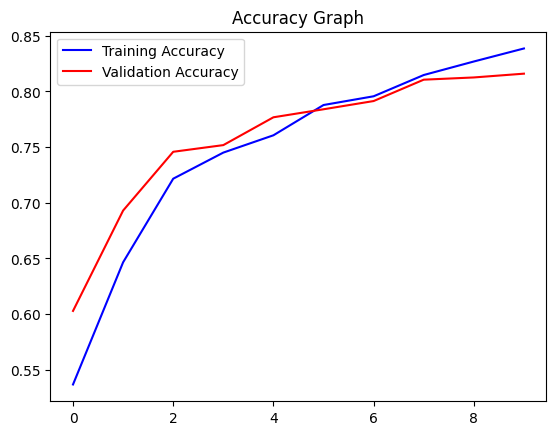

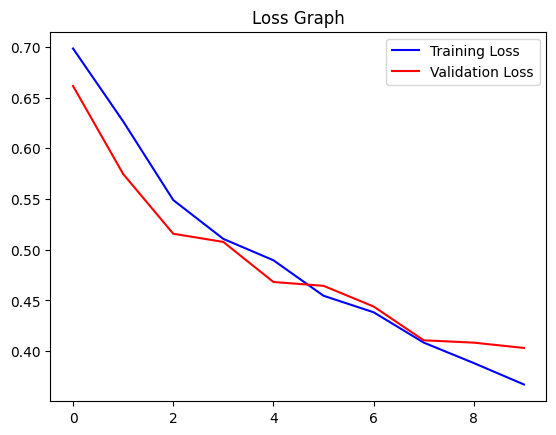

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
image_path = "test.jpg" # path of the image
img = load_img(image_path, target_size=(128, 128))
img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)